# "Just kidding" experiments

This notebook contains the code used for the "Just kidding" experiments in our paper.

# Setup

Import required libraries.

In [2]:
import transformer_lens
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
import pickle

import steering_opt
import get_dataset

import numpy as np
import tqdm

Load our instruction-tuned model.

In [8]:
device = 'cuda:7'
torch.set_default_device(device)
torch.cuda.set_device(device)

tokenizer = AutoTokenizer.from_pretrained("google/gemma-2-2b-it")
model = AutoModelForCausalLM.from_pretrained("google/gemma-2-2b-it").to(dtype=torch.bfloat16)

tokenizer = tokenizer
model = model.to(device=device)

Loading checkpoint shards: 100%|██████████████████| 2/2 [00:01<00:00,  1.53it/s]


Some helpful functions.

In [5]:
from functools import reduce
flatten = lambda z: reduce(lambda x,y: x+y, z)

import gc
def unoom():
    gc.collect()
    torch.cuda.empty_cache()

# Section 3.1: get steered generations

This section contains code for getting steered model generations using the different steering methods tested in Section 3.1: promotion steering, suppression steering, reentrant steering, and CAA steering (skyline).



## Unsteered generations

As a baseline, generate completions for our fictitious prompts without using any steering vectors.

In [27]:
unsteered_generations = [ [] for _ in range(len(get_dataset.split_names)) ]
import time
cleanup = lambda x: x.replace('<bos>', '').replace('<eos>', '').replace('<pad>', '')
for i in range(len(get_dataset.split_names)):
    prompts = [get_dataset.templates[(i+1)%len(get_dataset.split_names)].replace('{}', name) for name in get_dataset.entity_names[i]]
    print(len(prompts))

    start_time = time.time()
    token_info = tokenizer(prompts, padding=True, padding_side='left', return_tensors='pt').to(device)
    generated_tokens = model.generate(**token_info, use_cache=True, max_new_tokens=500, do_sample=False)
    end_time = time.time()
    print(end_time - start_time)
    print(generated_tokens.shape)

    unsteered_generations[i] = [cleanup(x) for x in tokenizer.batch_decode(generated_tokens)]

85


22.242743968963623
torch.Size([85, 242])
97
19.236999034881592
torch.Size([97, 259])
85
14.45975637435913
torch.Size([85, 223])
76
20.33755397796631
torch.Size([76, 322])
80
22.316227197647095
torch.Size([80, 332])
96
20.734482049942017
torch.Size([96, 275])


In [29]:
import pickle
with open('results/just_kidding/unsteered_gens.pkl', 'wb') as fp:
    pickle.dump(unsteered_generations, fp)

## Promotion steering

To get steered model generations, use the script `get_promotion_steering_gens.py`. This script automatically computes promotion steering vectors for each layer and each training dataset split, and parallelizes the process of computing steered generations across multiple devices. The script takes two command-line arguments:
* `devices`: a comma-separated list of GPU indices that all scripts (in parallel) will be using. E.g. `0,1,2,3` means that four scripts will be running in parallel, one using GPU 0, the next using GPU 1, etc.
* `device_idx`: the device index that the current script will be using.

For example, to split the generation workload across two GPUs, you can run this script twice in parallel:
* `python3 get_promotion_steering_gens.py 0,1 0 &`
* `python3 get_promotion_steering_gens.py 0,1 1 &`

The script saves results for the current device to the filename `'results/just_kidding/dst_generations_all_layers_{device_idx}.pkl'`, where `{device_idx}` is replaced with the proper device index.

### Merging results from different devices

After getting generations in parallel across different devices, it's time to merge the results into a single file.

In this code, we assume that `devices = [0,1,2,3]`.

In [2]:
import pickle
import numpy as np

num_devices = 4
num_layers = 26

dst_gens_per_device = []
for i in range(num_devices):
    with open(f'results/just_kidding/dst_generations_all_layers_{i}.pkl', 'rb') as fp:
        dst_gens_per_device.append(pickle.load(fp))

dst_gens_all_layers = [None for _ in range(num_layers)]
for x in dst_gens_per_device:
    for layer, v in x.items():
        dst_gens_all_layers[layer] = v

# save results to 'results/just_kidding/dst_generations_all_layers.pkl'
with open('results/just_kidding/dst_generations_all_layers.pkl', 'wb') as fp:
    pickle.dump(dst_gens_all_layers, fp)

## Suppression steering

Similarly to promotion steering, you can use the script `get_suppression_steering_gens.py` to get suppression-steered generations in parallel across multiple GPUs. The arguments are the same as `get_promotion_steering_gens.py`.

For example, to split the generation workload across two GPUs, you can run this script twice in parallel:
* `python3 get_suppression_steering_gens.py 0,1 0 &`
* `python3 get_suppression_steering_gens.py 0,1 1 &`

The script saves results for the current device to the filename `'results/just_kidding/src_generations_all_layers_{device_idx}.pkl'`, where `{device_idx}` is replaced with the proper device index.

### Merging results from different devices

After getting generations in parallel across different devices, it's time to merge the results into a single file.

In this code, we assume that `devices = [0,1,2,3]`.

In [2]:
import pickle
import numpy as np

num_devices = 4
num_layers = 26

dst_gens_per_device = []
for i in range(num_devices):
    with open(f'results/just_kidding/src_generations_all_layers_{i}.pkl', 'rb') as fp:
        dst_gens_per_device.append(pickle.load(fp))

dst_gens_all_layers = [None for _ in range(num_layers)]
for x in dst_gens_per_device:
    for layer, v in x.items():
        dst_gens_all_layers[layer] = v

# save results to 'results/just_kidding/dst_generations_all_layers.pkl'
with open('results/just_kidding/src_generations_all_layers.pkl', 'wb') as fp:
    pickle.dump(dst_gens_all_layers, fp)

## Reentrant steering

Because we only test out reentrant steering at a single point (lower-layer steering at layer 1 + higher-layer steering at layer 10), we don't use a separate parallelization script to compute steered generations. Instead, the code to compute generations is as follows.

### Steering functions

In [ ]:
import time
def get_generations(layer, vector, prompt_splits, split_names, sample_kwargs=None):
    if sample_kwargs is None: sample_kwargs = {}
    new_sample_kwargs = dict(use_cache=True, max_new_tokens=500, do_sample=False)
    new_sample_kwargs.update(sample_kwargs)

    generations_dict = {}
    cleanup = lambda x: x.replace('<bos>', '').replace('<eos>', '').replace('<pad>', '')
    for i in range(len(split_names)):
        start_time = time.time()
        with steering_opt.hf_hooks_contextmanager(model, [(layer, steering_opt.make_steering_hook_hf(vector))]):
            token_info = tokenizer(prompt_splits[i], padding=True, padding_side='left', return_tensors='pt').to(device)
            print(token_info.input_ids.shape)
            generated_tokens = model.generate(**token_info, **new_sample_kwargs)
        generations_dict[split_names[i]] = [cleanup(x) for x in tokenizer.batch_decode(generated_tokens)]
        end_time = time.time()
        print(f'Split {split_names[i]} finished in {end_time-start_time:.2f} seconds.')

    return generations_dict

In [38]:
def do_klmin(model, tokenizer, new_layer, all_target_tokens, all_base_hooks,
    token_slice=slice(None, None), steer_slice=None,
    lr=0.1,
    max_iters=40, target_loss=None, target_loss_target_iters=1,
    do_clamp=True,
    max_norm=30, starting_norm=0.5,
    eps=1e-9, debug=True
):
    all_target_logits = []
    with torch.no_grad():
        for cur_hook, cur_target_tokens in zip(all_base_hooks, all_target_tokens):
            with steering_opt.hf_hooks_contextmanager(model, [cur_hook]):
                cur_target_logits = model(cur_target_tokens).logits[:, token_slice]
                all_target_logits.append(cur_target_logits)
        
    new_vector = torch.randn(model.config.hidden_size).to(device)*starting_norm
    new_vector.requires_grad_(True)
    
    optimizer = torch.optim.Adam([new_vector], lr=lr)
    
    loss = None
    prev_loss = None
    iters = 0
    target_loss_cur_iters = 0
    prev_loss_cur_iters = 0
    
    while True:
        if max_iters is not None and iters > max_iters:
            if debug: print("Max iters reached.")	
            break
        if target_loss is not None and loss is not None:
            if loss <= (target_loss if not satisfice else target_loss + eps):
                target_loss_cur_iters += 1
                if debug: print(f"Loss stopping threshold {target_loss} hit. Cur num iters: {target_loss_cur_iters}")
            else:
                target_loss_cur_iters = 0
    
            if target_loss_cur_iters >= target_loss_target_iters:
                if debug: print(f"Loss stopping threshold {target_loss} hit. Breaking.")
                break
    
        optimizer.zero_grad()
        prev_loss = loss
        loss = 0
    
        for cur_target_logits, cur_target_tokens in zip(all_target_logits, all_target_tokens):
            if do_clamp: new_hook_fn = steering_opt.make_steering_hook_hf(new_vector, make_abl_mat(new_vector), token=steer_slice)
            else: new_hook_fn = steering_opt.make_steering_hook_hf(new_vector, token=steer_slice)
            with steering_opt.hf_hooks_contextmanager(model, [(new_layer, new_hook_fn)]):
                cur_steered_logits = model(cur_target_tokens).logits[:, token_slice]
            cur_loss = torch.nn.functional.kl_div(torch.nn.functional.softmax(cur_steered_logits, dim=-1).log(), torch.nn.functional.softmax(cur_target_logits, dim=-1), reduction='batchmean')/len(cur_target_logits[0])
            cur_loss.backward()
            loss += cur_loss.item()
        if debug: print(loss)
    
        if prev_loss is not None and abs(prev_loss - loss) < eps:
            prev_loss_cur_iters += 1
        if prev_loss_cur_iters >= target_loss_target_iters:
            if debug:
                print("prev_loss reached after", iters,'iters')
                print("prev_loss, loss:", prev_loss, loss)
            break
    
        optimizer.step()
    
        # if we've reached our max norm, then normalize our parameters
        with torch.no_grad():
            if max_norm is not None and (cur_norm := torch.linalg.norm(new_vector)) > max_norm:
                new_vector[:] = max_norm * new_vector / torch.linalg.norm(new_vector)
        
        iters += 1

    return new_vector

def do_klmin_reentrant(model, tokenizer, datapoints, base_layer, late_layer, generation_size=10, base_opt_kwargs=None, late_opt_kwargs=None, debug=False):
    # do base layer optimization
    if base_opt_kwargs is None: base_opt_kwargs = {}
    new_base_opt_kwargs = dict(lr=0.1, max_iters=50, use_transformer_lens=False,
        do_target_loss_avg=False, return_loss=False,
        affine_rank=1, max_norm=0, max_affine_norm=1,
        target_loss=0.01, target_loss_target_iters=20,
        debug=debug
    )
    new_base_opt_kwargs.update(base_opt_kwargs)

    if new_base_opt_kwargs['affine_rank'] is None:
        vector = steering_opt.optimize_completion(
            model, datapoints, base_layer, tokenizer=tokenizer, **new_base_opt_kwargs
        )
        base_hook = (base_layer, steering_opt.make_steering_hook_hf(vector))
    else:
        vector, matrix = steering_opt.optimize_completion(
            model, datapoints, base_layer, tokenizer=tokenizer, **new_base_opt_kwargs
        )
        base_hook = (base_layer, steering_opt.make_steering_hook_hf(vector, matrix))

    # generate steered tokens
    all_target_tokens = []
    for datapoint in datapoints:
        with steering_opt.hf_hooks_contextmanager(model, [base_hook]):
            target_tokens = model.generate(tokenizer(datapoint.prompt, return_tensors='pt').input_ids, use_cache=False, max_new_tokens=generation_size)
            all_target_tokens.append(target_tokens)

    # do late-layer optimization
    if late_opt_kwargs is None: late_opt_kwargs = {}
    new_late_opt_kwargs = dict(lr=0.1, max_iters=40, target_loss=None, target_loss_target_iters=2, max_norm=30, eps=1e-9, debug=debug)
    new_late_opt_kwargs.update(late_opt_kwargs)

    new_vector = do_klmin(model, tokenizer, late_layer, all_target_tokens, [base_hook], **new_late_opt_kwargs)
    return new_vector

In [69]:
def do_reentrant_steering_experiment_on_layer(base_layer, late_layer, fake_split_step=1, num_examples=1,
    reentrant_kwargs=None, sample_kwargs=None, num_sample_prompts_per_split=None):

    info = dict(
        fake_split_step=fake_split_step,
        num_examples=num_examples,
        reentrant_kwargs=reentrant_kwargs,
        sample_kwargs=sample_kwargs
    )
    
    if reentrant_kwargs is None: reentrant_kwargs = {}
    new_reentrant_kwargs = dict(generation_size=50,
        base_opt_kwargs=dict(
            do_target_loss_avg=False,
            affine_rank=1, max_norm=0, max_affine_norm=1,
            target_loss=0.01, target_loss_target_iters=20,
        ),
        late_opt_kwargs=dict(
            lr=0.1, max_iters=40, target_loss=None, target_loss_target_iters=2, max_norm=30, eps=1e-9, token_slice=slice(-50, -50+10)
        )
    )
    new_reentrant_kwargs.update(reentrant_kwargs)

    training_real_prompts = [random.sample(real_prompt_split, k=num_examples) for real_prompt_split in real_prompt_splits]
    training_fake_prompts = [[make_fake_prompt(dst_prompt, fake_split_step=fake_split_step) for dst_prompt in split] for split in training_real_prompts]
    all_fake_prompts = [[make_fake_prompt(prompt, fake_split_step=fake_split_step) for prompt in split] for split in real_prompt_splits]
    if num_sample_prompts_per_split is not None:
        all_fake_prompts = [random.sample(x, k=num_sample_prompts_per_split) for x in all_fake_prompts]
    info['sample_prompts'] = all_fake_prompts
    
    split_names = [f'{get_dataset.occupations[i][:3]}_to_{get_dataset.occupations[(i+fake_split_step)%len(get_dataset.occupations)][:3]}' for i in range(len(get_dataset.occupations))]

    info['generations'] = []
    #for real_prompt_split, fake_prompt_split in zip(training_real_prompts, training_fake_prompts
    for fake_prompt_split in training_fake_prompts:
        cur_split_info = []
        for src_prompt in fake_prompt_split:
            gc.collect()
            torch.cuda.empty_cache()
            datapoints = [
                steering_opt.TrainingDatapoint(
                    src_prompt,
                    src_completions=["...Just kidding", "... Just kidding"],
                )
            ]
            
            new_vector = do_klmin_reentrant(model, tokenizer,
                datapoints, base_layer, late_layer, **new_reentrant_kwargs
            )
            
            gc.collect()
            torch.cuda.empty_cache()
            generations_dict = get_generations(late_layer, new_vector, all_fake_prompts, split_names, sample_kwargs=sample_kwargs)
            cur_datapoint_info = {
                'src_prompt': src_prompt,
                'vector': new_vector.detach().cpu().float().numpy(),
                'reentrant_kwargs': new_reentrant_kwargs,
                'generations_dict': generations_dict
            }
            cur_split_info.append(cur_datapoint_info)
        info['generations'].append(cur_split_info)

    return info

### Get steered generations

In [70]:
import gc
reentrant_info = do_reentrant_steering_experiment_on_layer(1, 10, num_sample_prompts_per_split=40)

torch.Size([40, 37])
Split act_to_aut finished in 12.91 seconds.
torch.Size([40, 39])
Split aut_to_ath finished in 12.47 seconds.
torch.Size([40, 36])
Split ath_to_sci finished in 10.87 seconds.
torch.Size([40, 36])
Split sci_to_pol finished in 17.18 seconds.
torch.Size([40, 37])
Split pol_to_mus finished in 13.84 seconds.
torch.Size([40, 37])
Split mus_to_act finished in 12.38 seconds.
torch.Size([40, 37])
Split act_to_aut finished in 5.42 seconds.
torch.Size([40, 39])
Split aut_to_ath finished in 7.05 seconds.
torch.Size([40, 36])
Split ath_to_sci finished in 5.58 seconds.
torch.Size([40, 36])
Split sci_to_pol finished in 8.01 seconds.
torch.Size([40, 37])
Split pol_to_mus finished in 10.92 seconds.
torch.Size([40, 37])
Split mus_to_act finished in 9.03 seconds.
torch.Size([40, 37])
Split act_to_aut finished in 16.55 seconds.
torch.Size([40, 39])
Split aut_to_ath finished in 17.27 seconds.
torch.Size([40, 36])
Split ath_to_sci finished in 15.63 seconds.
torch.Size([40, 36])
Split sci

In [91]:
import pickle
with open("results/just_kidding/reentrant_1_10_gens.pkl", "wb") as fp:
    pickle.dump(reentrant_info, fp)

## CAA

For CAA just as reentrant steering, we don't use a separate script to parallelize generating steered completions.

In [47]:
layers = list(range(1,25,2)) # the layers at which we want to get generations
batch_size = 20 # larger batch sizes speed up generations but use more memory

First, get the mean difference vectors at each layer.

In [50]:
caa_vecs = {}

for new_layer in layers:
    print("Doing layer", new_layer)
    token_slice = slice(None, None)
    
    real_means = []
    fake_means = []
    
    for i in tqdm.tqdm(range(0, len(get_dataset.real_prompts), batch_size)):
        cur_real_prompts = get_dataset.real_prompts[i:i+batch_size]
        cur_fake_prompts = get_dataset.fake_prompts[i:i+batch_size]
    
        outlist = []
        activs_hook = (new_layer, steering_opt.make_activs_hook_hf(outlist))
        token_info = tokenizer(cur_real_prompts, return_tensors='pt', padding=True, padding_side='right')
        lengths = (token_info.input_ids != 0).sum(dim=-1).detach().cpu().numpy()
        with steering_opt.hf_hooks_contextmanager(model, [activs_hook]):
            model(**token_info)
        x = outlist[0].float()
        cur_mean = torch.stack([x[i, :lengths[i]].mean(dim=0) for i in range(len(x))]).mean(dim=0).detach().cpu().numpy()
        real_means.append(cur_mean)
            
        outlist = []
        activs_hook = (new_layer, steering_opt.make_activs_hook_hf(outlist))
        token_info = tokenizer(cur_fake_prompts, return_tensors='pt', padding=True, padding_side='right')
        lengths = (token_info.input_ids != 0).sum(dim=-1).detach().cpu().numpy()
        with steering_opt.hf_hooks_contextmanager(model, [activs_hook]):
            model(**token_info)
        x = outlist[0].float()
        cur_mean = torch.stack([x[i, :lengths[i]].mean(dim=0) for i in range(len(x))]).mean(dim=0).detach().cpu().numpy()
        fake_means.append(cur_mean)
    
        if i % (3*batch_size) == 0:
            gc.collect()
            torch.cuda.empty_cache()

    total_real_mean = np.array(real_means).mean(axis=0)
    total_fake_mean = np.array(fake_means).mean(axis=0)
    total_diff_vec = total_real_mean - total_fake_mean
    caa_vecs[new_layer] =  total_diff_vec

Doing layer 1


100%|███████████████████████████████████████████| 26/26 [00:10<00:00,  2.47it/s]


Doing layer 3


100%|███████████████████████████████████████████| 26/26 [00:10<00:00,  2.56it/s]


Doing layer 5


100%|███████████████████████████████████████████| 26/26 [00:10<00:00,  2.51it/s]


Doing layer 7


100%|███████████████████████████████████████████| 26/26 [00:10<00:00,  2.51it/s]


Doing layer 9


100%|███████████████████████████████████████████| 26/26 [00:10<00:00,  2.58it/s]


Doing layer 11


100%|███████████████████████████████████████████| 26/26 [00:10<00:00,  2.39it/s]


Doing layer 13


100%|███████████████████████████████████████████| 26/26 [00:09<00:00,  2.69it/s]


Doing layer 15


100%|███████████████████████████████████████████| 26/26 [00:09<00:00,  2.65it/s]


Doing layer 17


100%|███████████████████████████████████████████| 26/26 [00:08<00:00,  2.94it/s]


Doing layer 19


100%|███████████████████████████████████████████| 26/26 [00:09<00:00,  2.73it/s]


Doing layer 21


100%|███████████████████████████████████████████| 26/26 [00:09<00:00,  2.79it/s]


Doing layer 23


100%|███████████████████████████████████████████| 26/26 [00:09<00:00,  2.87it/s]


Now, get steered generations at each layer.

In [83]:
caa_all_generations = {}
for layer, vec in caa_vecs.items():
    vec = torch.from_numpy(vec).to(device)
    generations_dict = {}
    import time
    cleanup = lambda x: x.replace('<bos>', '').replace('<eos>', '').replace('<pad>', '')
    print("=== Beginning layer", layer, "===")
    layer_start_time = time.time()
    for i in range(len(split_names)):
        prompts = [get_dataset.templates[(i+1)%len(split_names)].replace('{}', name) for name in entity_names[i]][:40]
        print('\t', len(prompts))
    
        start_time = time.time()
        hook = steering_opt.make_steering_hook_hf(vec, steering_opt.make_abl_mat(vec))
        with steering_opt.hf_hooks_contextmanager(model, [(layer, hook)]):
            token_info = tokenizer(prompts, padding=True, padding_side='left', return_tensors='pt').to(device)
            generated_tokens = model.generate(**token_info, use_cache=True, max_new_tokens=500, do_sample=False)
        end_time = time.time()
        print('\t', end_time - start_time)
        print('\t', generated_tokens.shape)
    
        generations_dict[split_names[i]] = [cleanup(x) for x in tokenizer.batch_decode(generated_tokens)]
        del generated_tokens
        del token_info
        unoom()
    layer_end_time = time.time()
    print("Layer", layer, "finished in", layer_end_time, "secs")
    caa_all_generations[layer] = generations_dict

=== Beginning layer 1 ===
	 40
	 14.15922737121582
	 torch.Size([40, 252])
	 40
	 16.70496129989624
	 torch.Size([40, 295])
	 40
	 14.430785179138184
	 torch.Size([40, 210])
	 40
	 17.893643856048584
	 torch.Size([40, 243])
	 40
	 19.297858953475952
	 torch.Size([40, 272])
	 40
	 13.283156633377075
	 torch.Size([40, 244])
Layer 1 finished in 1738040488.9757278 secs
=== Beginning layer 3 ===
	 40
	 13.006235122680664
	 torch.Size([40, 241])
	 40
	 16.42029881477356
	 torch.Size([40, 277])
	 40
	 14.240000486373901
	 torch.Size([40, 204])
	 40
	 16.17931890487671
	 torch.Size([40, 229])
	 40
	 13.536789417266846
	 torch.Size([40, 241])
	 40
	 14.101921558380127
	 torch.Size([40, 236])
Layer 3 finished in 1738040578.0246103 secs
=== Beginning layer 5 ===
	 40
	 15.510012865066528
	 torch.Size([40, 254])
	 40
	 17.008780479431152
	 torch.Size([40, 287])
	 40
	 15.319780588150024
	 torch.Size([40, 264])
	 40
	 15.552603006362915
	 torch.Size([40, 264])
	 40
	 18.427552223205566
	 torch.Size

Save our steering vectors and generations.

In [97]:
import pickle
with open('results/just_kidding/caa_generations_all_layers.pkl', 'wb') as fp:
    pickle.dump(caa_all_generations, fp)
with open('results/just_kidding/caa_vecs_all_layers.pkl', 'wb') as fp:
    pickle.dump(caa_vecs, fp)

# Section 3.2: qualitative analysis

## String analysis

How many times do "just kidding!"-related strings appear in steered generations? This section contains code to calculate this.

### Unsteered generations

In [1]:
import pickle
import matplotlib.pyplot as plt
import numpy as np

with open('results/just_kidding/unsteered_gens.pkl', 'rb') as fp:
    unsteered_gens = pickle.load(fp)

In [2]:
needles = ['ust kidding', 'trick question', "hat's not right", "might be confused", "his is a joke"]
counts = [0 for _ in needles]
total = 0

none_found_idxs = []
none_found_count_per_split = [0 for _ in unsteered_gens]

for split_idx, split in enumerate(unsteered_gens):
    for gen_idx, gen in enumerate(split):
        found = False
        for i, needle in enumerate(needles):
            if needle in gen:
                counts[i] += 1
                found = True
        if not found:
            none_found_idxs.append((split_idx, gen_idx))
            none_found_count_per_split[split_idx] += 1
        total += 1

print(np.array(counts)/total)
print(none_found_idxs)
print(none_found_count_per_split)
print(len(none_found_idxs)/total)

[0.46242775 0.20038536 0.00192678 0.00963391 0.06165703]
[(0, 1), (0, 4), (0, 11), (0, 13), (0, 16), (0, 17), (0, 23), (0, 24), (0, 28), (0, 30), (0, 31), (0, 35), (0, 37), (0, 40), (0, 43), (0, 52), (0, 56), (0, 57), (0, 60), (0, 63), (0, 66), (0, 68), (0, 69), (0, 74), (0, 77), (0, 84), (1, 21), (2, 5), (2, 9), (2, 27), (2, 28), (2, 34), (2, 63), (2, 69), (2, 71), (2, 81), (2, 82), (2, 83), (3, 10), (3, 31), (3, 33), (3, 36), (3, 37), (3, 38), (3, 44), (3, 48), (3, 52), (3, 62), (3, 64), (3, 66), (3, 67), (3, 69), (3, 74), (4, 1), (4, 2), (4, 4), (4, 10), (4, 15), (4, 16), (4, 17), (4, 23), (4, 26), (4, 29), (4, 36), (4, 37), (4, 41), (4, 49), (4, 54), (4, 55), (4, 60), (4, 65), (4, 66), (4, 68), (4, 72), (4, 73), (4, 75), (5, 2), (5, 4), (5, 5), (5, 6), (5, 9), (5, 13), (5, 14), (5, 15), (5, 17), (5, 24), (5, 25), (5, 27), (5, 29), (5, 30), (5, 31), (5, 32), (5, 33), (5, 35), (5, 36), (5, 37), (5, 38), (5, 39), (5, 40), (5, 41), (5, 42), (5, 43), (5, 44), (5, 45), (5, 46), (5, 47), 

In [3]:
1-0.2678227360308285

0.7321772639691715

### Promotion steering

In [7]:
import pickle
with open('results/just_kidding/dst_generations_all_layers.pkl', 'rb') as fp:
    dst_generations_all_layers = pickle.load(fp)

In [8]:
dst_counts = [[0 for _ in needles] for layer in range(26)]
dst_total = [0 for layer in range(26)]
dst_none_found_count = [0 for layer in range(26)]

for layer, layer_gens in enumerate(dst_generations_all_layers):
    layer_gens = layer_gens['generations']
    for training_split_idx, training_split in enumerate(layer_gens):
        for split_name, split in training_split[0]['generations_dict'].items():
            for gen in split:
                found = False
                for i, needle in enumerate(needles):
                    if needle in gen:
                        dst_counts[layer][i] += 1
                        found = True
                if not found:
                    dst_none_found_count[layer] += 1
                dst_total[layer] += 1

### Suppression steering

In [5]:
import pickle
with open('results/just_kidding/src_generations_all_layers.pkl', 'rb') as fp:
    src_generations_all_layers = pickle.load(fp)

In [6]:
src_counts = [[0 for _ in needles] for layer in range(26)]
src_total = [0 for layer in range(26)]
src_none_found_count = [0 for layer in range(26)]

for layer, layer_gens in enumerate(src_generations_all_layers):
    layer_gens = layer_gens['generations']
    for training_split_idx, training_split in enumerate(layer_gens):
        for split_name, split in training_split[0]['generations_dict'].items():
            for gen in split:
                found = False
                for i, needle in enumerate(needles):
                    if needle in gen:
                        src_counts[layer][i] += 1
                        found = True
                if not found:
                    src_none_found_count[layer] += 1
                src_total[layer] += 1

### Reentrant

In [14]:
with open("reentrant_1_10_gens.pkl", "rb") as fp:
    reentrant_1_10_gens = pickle.load(fp)

reentrant_counts = [0 for _ in needles]
reentrant_total = 0
reentrant_none_found_count = 0 

for training_split_idx, training_split in enumerate(reentrant_1_10_gens['generations']):
    for split_name, split in training_split[0]['generations_dict'].items():
        for gen in split:
            found = False
            for i, needle in enumerate(needles):
                if needle in gen:
                    reentrant_counts[i] += 1
                    found = True
            if not found:
                reentrant_none_found_count += 1
            reentrant_total += 1

### CAA

In [11]:
import pickle
with open('results/just_kidding/caa_generations_all_layers.pkl', 'rb') as fp:
    caa_generations_all_layers = pickle.load(fp)

caa_layers = caa_generations_all_layers.keys()

caa_counts = {layer: [0 for _ in needles] for layer in caa_layers}
caa_total = {layer: 0 for layer in caa_layers}
caa_none_found_count = {layer: 0 for layer in caa_layers}

for layer, layer_gens in caa_generations_all_layers.items():
    for split_name, split in layer_gens.items():
        for gen in split:
            found = False
            for i, needle in enumerate(needles):
                if needle in gen:
                    caa_counts[layer][i] += 1
                    found = True
            if not found:
                caa_none_found_count[layer] += 1
            caa_total[layer] += 1

### Plot all results

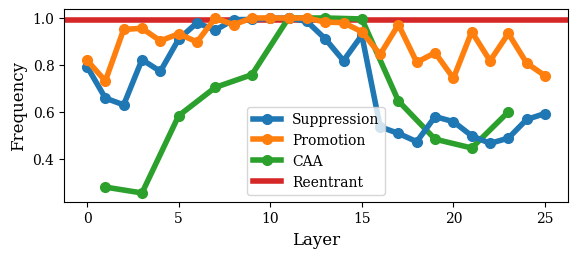

In [49]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['lines.linewidth'] = 4
plt.rcParams['lines.markersize'] = 14

plt.plot(np.array(src_none_found_count)/np.array(src_total), label='Suppression', marker='.')

plt.plot(np.array(dst_none_found_count)/np.array(dst_total), label='Promotion', marker='.')

plt.plot(caa_layers, np.array(list(caa_none_found_count.values()))/np.array(list(caa_total.values())), label='CAA', marker='.', zorder=-1)

plt.axhline(np.array(reentrant_none_found_count)/np.array(reentrant_total), label='Reentrant', color='C3', zorder=-2)

plt.gca().figure.set_size_inches(6.5, 2.5)

plt.legend()
#plt.title("Fraction of steered generations containing no JK strings")
plt.xlabel("Layer", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.show()

Get the maximum (over all layers) fraction of examples in which no JK-related strings are found.

In [199]:
print(np.max((np.array(src_none_found_count)/np.array(src_total))))

print(np.max((np.array(dst_none_found_count)/np.array(dst_total))))

print(np.max((np.array(list(caa_none_found_count.values()))/np.array(list(caa_total.values())))))

print(np.array(reentrant_none_found_count)/np.array(reentrant_total))

1.0
1.0
1.0
0.9895833333333334


## LLM qualitative evaluations

### Promotion / suppression / CAA steering

To perform LLM qualitative evaluations, use the script `llm_evals.py`. This script parallelizes the computation of having an LLM evaluate whether a steered generation primarily discusses the original attribute of the entity or the fictitious attribute of the entity.

This script takes the following command-line arguments:

* `devices`: a comma-separated list of ints containing a list of GPU indices that the scripts will be using. E.g. `0,1,2,3` means that across all instances of the running scripts, GPUs 0, 1, 2, and 3 will be used.
* `device_idx`: the GPU index that this current script instance will be using. Note that this is an index into the list provided by `devices`, so if `devices` is `0,2,4`, and `device_idx` is `1`, then the script will run on GPU 2.
* `generations_path`: the path to a `.pkl` file containing the generations to be evaluated. (This is the same `.pkl` file output by the code from Section 3.1.)
* `out_prefix` (optional): a prefix for where our output file will be saved. In particular, a script running with device index `device_idx` will output to `'{out_prefix}device_{device_idx}.pkl'`.
* `layer_range` (optional): a comma-separated triple of ints `start,end,step` corresponding to a range of layers to evaluate.
* `only_one_training_split` (optional): if true, then the generations file only contains generations from a single steering vector per layer. In our setup, this is true for CAA.

**Examples**:
* To evaluate suppression-steered generations saved to `results/just_kidding/src_generations_all_layers.pkl` on GPUs 0, 2, and 4, only looking at layers 1,3,5,...,23, then run the following commands (in parallel):
    * `python3 llm_evals.py 0,2,4 0 results/just_kidding/src_generations_all_layers.pkl results/just_kidding/src_llm_evals/ 1,25,2 &`
    * `python3 llm_evals.py 0,2,4 1 results/just_kidding/src_generations_all_layers.pkl results/just_kidding/src_llm_evals/ 1,25,2 &`
    * `python3 llm_evals.py 0,2,4 2 results/just_kidding/src_generations_all_layers.pkl results/just_kidding/src_llm_evals/ 1,25,2 &`

This will save results to the subdirectory `results/just_kidding/src_llm_evals/`.
* To evaluate CAA-steered generations saved to `results/just_kidding/caa_generations_all_layers.pkl` on GPUs 0, 2, and 4, only looking at layers 1,4,7,...,24, then run the following commands (in parallel):
    * `python3 llm_evals.py 0,2,4 0 results/just_kidding/caa_generations_all_layers.pkl results/just_kidding/caa_llm_evals/ 1,25,3 true &`
    * `python3 llm_evals.py 0,2,4 1 results/just_kidding/caa_generations_all_layers.pkl results/just_kidding/caa_llm_evals/ 1,25,3 true &`
    * `python3 llm_evals.py 0,2,4 2 results/just_kidding/caa_generations_all_layers.pkl results/just_kidding/caa_llm_evals/ 1,25,3 true &`

This will save results to the subdirectory `results/just_kidding/caa_llm_evals/`.

After running this script, the next step is to gather up the results from all devices into a single datastructure.

#### Suppression steering

The following code assumes that 4 devices were used for parallelism, and that outputs were saved under the directory `results/just_kidding/src_llm_evals/`.

In [52]:
import pickle
num_devices = 4

src_llm_evals_arr = []
for i in range(num_devices):
    with open(f'results/just_kidding/src_llm_evals/device_{i}.pkl', 'rb') as fp:
        src_llm_evals_arr.append(pickle.load(fp))


src_probs_all = {
    'src_mentioned': { layer: 0 for layer in src_llm_evals['probs'].keys() },
    'src_primary': { layer: 0 for layer in src_llm_evals['probs'].keys() } ,
    'dst_mentioned': { layer: 0 for layer in src_llm_evals['probs'].keys() } ,
    'dst_primary': { layer: 0 for layer in src_llm_evals['probs'].keys() },
    'total': { layer: 0 for layer in src_llm_evals['probs'].keys() } 
}

for cur_src_llm_evals in src_llm_evals_arr:
    for layer, layer_probs in cur_src_llm_evals['probs'].items():
        for training_split_idx, training_split in enumerate(layer_probs):
            for eval_split_idx, eval_split in enumerate(training_split):
                total = eval_split[0].shape[0]
                src_mentioned = np.sum(eval_split[0][:, 0] > 0.5)
                src_primary = np.sum(eval_split[1][:, 0] > 0.5)
                dst_mentioned = np.sum(eval_split[2][:, 0] > 0.5)
                dst_primary = np.sum(eval_split[3][:, 0] > 0.5)
    
                src_probs_all['total'][layer] += total
                src_probs_all['src_mentioned'][layer] += src_mentioned
                src_probs_all['src_primary'][layer] += src_primary
                src_probs_all['dst_mentioned'][layer] += dst_mentioned
                src_probs_all['dst_primary'][layer] += dst_primary

#### Promotion steering
The following code assumes that 4 devices were used for parallelism, and that outputs were saved under the directory `results/just_kidding/dst_llm_evals/`.

In [53]:
num_devices = 4

dst_llm_evals_arr = []
for i in range(num_devices):
    with open(f'results/just_kidding/dst_llm_evals/device_{i}.pkl', 'rb') as fp:
        dst_llm_evals_arr.append(pickle.load(fp))

dst_probs_all = {
    'src_mentioned': { layer: 0 for layer in dst_llm_evals['probs'].keys() },
    'src_primary': { layer: 0 for layer in dst_llm_evals['probs'].keys() } ,
    'dst_mentioned': { layer: 0 for layer in dst_llm_evals['probs'].keys() } ,
    'dst_primary': { layer: 0 for layer in dst_llm_evals['probs'].keys() },
    'total': { layer: 0 for layer in dst_llm_evals['probs'].keys() } 
}

for cur_dst_llm_evals in dst_llm_evals_arr:
    for layer, layer_probs in cur_dst_llm_evals['probs'].items():
        for training_split_idx, training_split in enumerate(layer_probs):
            for eval_split_idx, eval_split in enumerate(training_split):
                if eval_split[0] is None: continue
                total = eval_split[0].shape[0]
                src_mentioned = np.sum(eval_split[0][:, 0] > 0.5)
                src_primary = np.sum(eval_split[1][:, 0] > 0.5)
                dst_mentioned = np.sum(eval_split[2][:, 0] > 0.5)
                dst_primary = np.sum(eval_split[3][:, 0] > 0.5)
    
                dst_probs_all['total'][layer] += total
                dst_probs_all['src_mentioned'][layer] += src_mentioned
                dst_probs_all['src_primary'][layer] += src_primary
                dst_probs_all['dst_mentioned'][layer] += dst_mentioned
                dst_probs_all['dst_primary'][layer] += dst_primary

#### CAA steering

The following code assumes that 4 devices were used for parallelism, and that outputs were saved under the directory `results/just_kidding/caa_llm_evals/`.

In [55]:
num_devices = 4

caa_llm_evals_arr = []

for i in range(num_devices):
    with open(f'results/just_kidding/caa_llm_evals/device_{i}.pkl', 'rb') as fp:
        caa_llm_evals_arr.append(pickle.load(fp))

caa_probs_all = {
    'src_mentioned': { layer: 0 for layer in dst_llm_evals['probs'].keys() },
    'src_primary': { layer: 0 for layer in dst_llm_evals['probs'].keys()  } ,
    'dst_mentioned': { layer: 0 for layer in dst_llm_evals['probs'].keys() } ,
    'dst_primary': { layer: 0 for layer in dst_llm_evals['probs'].keys() },
    'total': { layer: 0 for layer in dst_llm_evals['probs'].keys() } 
}

for cur_caa_llm_evals in caa_llm_evals_arr:
    for layer, layer_probs in cur_caa_llm_evals['probs'].items():
        for eval_split_idx, eval_split in enumerate(layer_probs[0]):
            # if eval_split[0] is None: continue
            total = eval_split[0].shape[0]
            src_mentioned = np.sum(eval_split[0][:, 0] > 0.5)
            src_primary = np.sum(eval_split[1][:, 0] > 0.5)
            dst_mentioned = np.sum(eval_split[2][:, 0] > 0.5)
            dst_primary = np.sum(eval_split[3][:, 0] > 0.5)

            caa_probs_all['total'][layer] += total
            caa_probs_all['src_mentioned'][layer] += src_mentioned
            caa_probs_all['src_primary'][layer] += src_primary
            caa_probs_all['dst_mentioned'][layer] += dst_mentioned
            caa_probs_all['dst_primary'][layer] += dst_primary

### Reentrant steering

For reentrant steering, instead of using a parallelizing script to evaluate generations, run the below code.

In [267]:
with open('results/just_kidding/reentrant_1_10_gens.pkl', 'rb') as fp:
    reentrant_steered_gens = pickle.load(fp)

reentrant_yes_probs = [ # training split
    [ # eval split
        [None, None, None, None]
    for _ in range(6) ]
for _ in range(6)]
    
reentrant_outdict = {'probs': reentrant_yes_probs, 'eval_templates': eval_templates}
reentrant_outpath = 'results/just_kidding/reentrant_llm_evals.pkl'

batch_size = 6
for training_split_idx in range(6):
    for eval_split_idx in tqdm.tqdm(range(6)):
        src_occupation = get_dataset.occupations[eval_split_idx]
        dst_occupation = get_dataset.occupations[(eval_split_idx+1)%len(occupations)]
        src_attrib = get_dataset.get_indef_article(src_occupation) + src_occupation
        dst_attrib = get_dataset.get_indef_article(dst_occupation) + dst_occupation

        split = list(reentrant_steered_gens['generations'][training_split_idx][0]['generations_dict'].values())[eval_split_idx]
        split = split[:40]

        eval_prompts = make_behavioral_eval_prompts(split, eval_template=eval_templates['has_attrib'], eval_args=dict(entity_attribute=src_attrib))
        src_mentioned = get_batch_yes_probs(eval_prompts, batch_size=batch_size)
        unoom()
        
        eval_prompts = make_behavioral_eval_prompts(split, eval_template=eval_templates['primary_attribute'], eval_args=dict(entity_attribute=src_attrib))
        src_primary = get_batch_yes_probs(eval_prompts, batch_size=batch_size)
        unoom()
        
        eval_prompts = make_behavioral_eval_prompts(split, eval_template=eval_templates['has_attrib'], eval_args=dict(entity_attribute=dst_attrib))
        dst_mentioned = get_batch_yes_probs(eval_prompts, batch_size=batch_size)
        unoom()
        
        eval_prompts = make_behavioral_eval_prompts(split, eval_template=eval_templates['primary_attribute'], eval_args=dict(entity_attribute=dst_attrib))
        dst_primary = get_batch_yes_probs(eval_prompts, batch_size=batch_size)
        unoom()

        reentrant_yes_probs[training_split_idx][eval_split_idx] = [src_mentioned, src_primary, dst_mentioned, dst_primary]

        with open(reentrant_outpath, 'wb') as fp:
            pickle.dump(reentrant_outdict, fp)

100%|█████████████████████████████████████████████| 6/6 [01:37<00:00, 16.19s/it]


### Plot all results

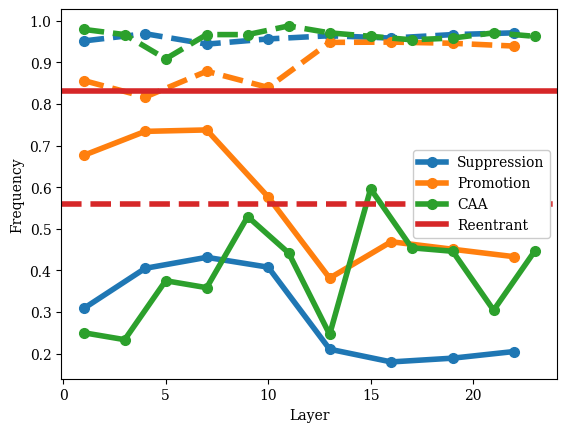

In [58]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'serif'

plt.plot(src_probs_all['src_mentioned'].keys(),
    np.array(list(src_probs_all['src_mentioned'].values()))/np.array(list(src_probs_all['total'].values())),
    color='C0', linestyle='dashed', marker='.'
)
plt.plot(src_probs_all['dst_mentioned'].keys(),
    np.array(list(src_probs_all['dst_mentioned'].values()))/np.array(list(src_probs_all['total'].values())),
    color='C0', label='Suppression', marker='.'
)

plt.plot(dst_probs_all['src_mentioned'].keys(),
    np.array(list(dst_probs_all['src_mentioned'].values()))/np.array(list(dst_probs_all['total'].values())),
    color='C1', linestyle='dashed', marker='.'
)
plt.plot(dst_probs_all['dst_mentioned'].keys(),
    np.array(list(dst_probs_all['dst_mentioned'].values()))/np.array(list(dst_probs_all['total'].values())),
    color='C1', label='Promotion', marker='.'
)

plt.plot(caa_probs_all['src_mentioned'].keys(),
    np.array(list(caa_probs_all['src_mentioned'].values()))/np.array(list(caa_probs_all['total'].values())),
    color='C2', linestyle='dashed', marker='.'
)
plt.plot(caa_probs_all['dst_mentioned'].keys(),
    np.array(list(caa_probs_all['dst_mentioned'].values()))/np.array(list(caa_probs_all['total'].values())),
    color='C2', label='CAA', marker='.'
)

plt.axhline(reentrant_probs_all['src_mentioned']/reentrant_probs_all['total'],
    color='C3', linestyle='dashed',
)
plt.axhline(reentrant_probs_all['dst_mentioned']/reentrant_probs_all['total'],
    color='C3', label='Reentrant',
)
plt.legend(framealpha=1)
plt.xlabel("Layer")
plt.ylabel("Frequency")

#plt.title("Frequency of fictitious (solid) / real (dashed) attribute\nappearance in steered generations")
plt.show()

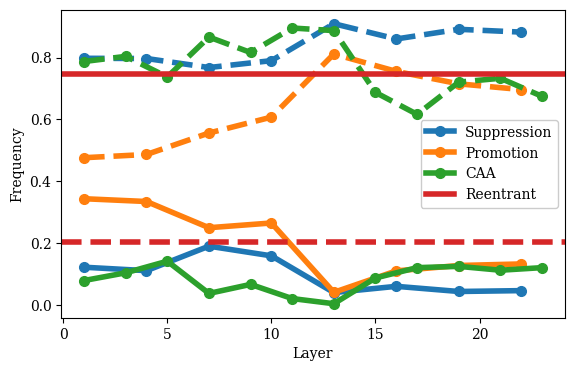

In [61]:
import matplotlib.pyplot as plt

plt.plot(src_probs_all['src_primary'].keys(),
    np.array(list(src_probs_all['src_primary'].values()))/np.array(list(src_probs_all['total'].values())),
    color='C0', linestyle='dashed', marker='.'
)
plt.plot(src_probs_all['dst_primary'].keys(),
    np.array(list(src_probs_all['dst_primary'].values()))/np.array(list(src_probs_all['total'].values())),
    color='C0', label='Suppression', marker='.'
)

plt.plot(dst_probs_all['src_primary'].keys(),
    np.array(list(dst_probs_all['src_primary'].values()))/np.array(list(dst_probs_all['total'].values())),
    color='C1', linestyle='dashed', marker='.'
)
plt.plot(dst_probs_all['dst_primary'].keys(),
    np.array(list(dst_probs_all['dst_primary'].values()))/np.array(list(dst_probs_all['total'].values())),
    color='C1', label='Promotion', marker='.'
)

plt.plot(caa_probs_all['src_primary'].keys(),
    np.array(list(caa_probs_all['src_primary'].values()))/np.array(list(caa_probs_all['total'].values())),
    color='C2', linestyle='dashed', marker='.'
)
plt.plot(caa_probs_all['dst_primary'].keys(),
    np.array(list(caa_probs_all['dst_primary'].values()))/np.array(list(caa_probs_all['total'].values())),
    color='C2', label='CAA', marker='.'
)

plt.axhline(reentrant_probs_all['src_primary']/reentrant_probs_all['total'],
    color='C3', linestyle='dashed'
)
plt.axhline(reentrant_probs_all['dst_primary']/reentrant_probs_all['total'],
    color='C3', label='Reentrant'
)

plt.gca().figure.set_size_inches(6.5, 4)

plt.legend(framealpha=1)
plt.xlabel("Layer")
plt.ylabel("Frequency")
#plt.title("Frequency of fictitious (solid) / real (dashed) attribute\nas main topic in steered generations")
plt.show()

# Section 3.3: Quantitative analysis

## Load base model

In [77]:
tokenizer = AutoTokenizer.from_pretrained("google/gemma-2-2b")
base_model = AutoModelForCausalLM.from_pretrained("google/gemma-2-2b").to(dtype=torch.bfloat16).to(device=device)

Loading checkpoint shards: 100%|██████████████████| 3/3 [00:01<00:00,  1.74it/s]


## Setup functions

In [108]:
flatten = lambda l: list(reduce(lambda x,y: x+y, l))

make_prompt = lambda name, occupation: get_dataset.template.replace('{article}', get_indef_article(occupation)).replace('{occupation}', occupation).replace('{}', name)

def extract_occupation_from_prompt(p):
    a = lambda x: get_dataset.get_indef_article(x) + '**' + x + '**'
    for i, occupation in enumerate(get_dataset.occupations):
        if a(occupation) in p: return occupation

def get_p_and_c(gen):
    p = make_prompt(extract_name_from_prompt(gen), extract_occupation_from_prompt(gen))
    c = gen[len(p):]
    p = p.replace('<start_of_turn>', '< start_of_turn >').replace('<end_of_turn>', '< end_of_turn >')
    c = c.replace('<start_of_turn>', '< start_of_turn >').replace('<end_of_turn>', '< end_of_turn >')
    return p, c

@torch.no_grad()
def get_prob_for_completion(model, tokenizer, context, prompt, completion, do_plot=False):    
    base_len = len(tokenizer(context + prompt).input_ids)
    completion_len = len(tokenizer(context + prompt + completion).input_ids) - base_len
    logits = model(tokenizer(context + prompt + completion, return_tensors='pt').input_ids, use_cache=False, num_logits_to_keep=completion_len+1).logits.to(dtype=torch.bfloat16)
    probs = torch.nn.functional.softmax(logits, dim=-1)
    del logits
    completion_probs = []
    all_tokens = tokenizer(context + prompt + completion).input_ids
    for i in range(len(all_tokens) - base_len):
        prob = probs[0, i, all_tokens[base_len + i]].item()
        completion_probs.append(prob)
    del probs
    completion_probs = np.array(completion_probs)
    if do_plot:
        plt.plot(completion_probs)
        plt.show()
    return completion_probs

@torch.no_grad()
def get_probs_for_gens(model, tokenizer, ctx, gens, split_len=40, gc_interval=3):
    probs = [[] for _ in gens]
    for i, split in enumerate(gens):
        split = [x for x in split if extract_name_from_prompt(x) not in ctx]
        split = split[:40]
        for gen in tqdm.tqdm(split):
            p, c = get_p_and_c(gen)
            if extract_name_from_prompt(p) in ctx: continue
            prob = get_prob_for_completion(model, tokenizer, ctx, p, c, do_plot=False)
            probs[i].append(prob)
        if i % gc_interval == 0: unoom()
    return probs

## Get contexts

This section contains code for getting our real, incongruous, and fictitious contexts.

First, get model generations on real prompts.

In [ ]:
import time
def get_generations(layer, vector, prompt_splits, split_names, sample_kwargs=None):
    if sample_kwargs is None: sample_kwargs = {}
    new_sample_kwargs = dict(use_cache=True, max_new_tokens=500, do_sample=False)
    new_sample_kwargs.update(sample_kwargs)

    generations_dict = {}
    cleanup = lambda x: x.replace('<bos>', '').replace('<eos>', '').replace('<pad>', '')
    for i in range(len(split_names)):
        start_time = time.time()
        with steering_opt.hf_hooks_contextmanager(model, [(layer, steering_opt.make_steering_hook_hf(vector))]):
            token_info = tokenizer(prompt_splits[i], padding=True, padding_side='left', return_tensors='pt').to(device)
            print(token_info.input_ids.shape)
            generated_tokens = model.generate(**token_info, **new_sample_kwargs)
        generations_dict[split_names[i]] = [cleanup(x) for x in tokenizer.batch_decode(generated_tokens)]
        end_time = time.time()
        print(f'Split {split_names[i]} finished in {end_time-start_time:.2f} seconds.')

    return generations_dict

In [ ]:
real_gens = get_generations(0,0,get_dataset.real_prompt_splits,get_dataset.occupations)

In [83]:
with open('results/just_kidding/real_gens.pkl', 'wb') as fp:
    pickle.dump(real_gens, fp)

### Real context

In [111]:
with open('results/just_kidding/real_gens.pkl', 'rb') as fp:
    real_gens = pickle.load(fp)

import random
ctx_prompts = []
for cur_prompts in real_gens.values():
    ctx_prompts = ctx_prompts + random.sample(cur_prompts, k=2)
random.shuffle(ctx_prompts)
real_ctx = '\n'.join(ctx_prompts)
real_ctx = real_ctx.replace('<', '< ').replace('>', ' >')

with open('results/just_kidding/real_ctx.pkl', 'wb') as fp:
    pickle.dump(real_ctx, fp)

### Fictitious context

In [111]:
import random
import time
ctx_prompts = []
for _ in range(2):
    for i, cur_prompts in enumerate(real_gens.values()):
        fake_prompt = None
        while fake_prompt is None or fake_prompt in ctx_prompts:
            fake_prompt = random.choice(cur_prompts)
        
        fake_name = None
        while fake_name is None:
            fake_name_idx = random.choice(range(len(get_dataset.entity_names[(i+1)%len(get_dataset.entity_names)])))
            fake_name_ = get_dataset.entity_names[(i+1)%len(get_dataset.entity_names)][fake_name_idx]
            if fake_name_ in "\n".join(ctx_prompts): continue
            fake_name_gen = real_gens[get_dataset.occupations[(i+1)%len(get_dataset.entity_names)]][fake_name_idx]
            if get_gender(fake_name_gen) != get_gender(fake_prompt):
                continue
            fake_name = fake_name_
            break
        fake_prompt = replace_name(fake_prompt, fake_name)
            
        ctx_prompts = ctx_prompts + [fake_prompt]
random.shuffle(ctx_prompts)
fake_ctx = '\n'.join(ctx_prompts).replace('<start_of_turn>', '< start_of_turn >').replace('<end_of_turn>', '< end_of_turn >') + "\n"

with open('results/just_kidding/fake_ctx.pkl', 'wb') as fp:
    pickle.dump(fake_ctx, fp)

## Layer 10 log-probs w.r.t. real and fictitious contexts (Tab. 1)

### Suppression steering

#### Fictitious context

In [50]:
prompt_end = '**.\n\n'

with open('results/just_kidding/src_generations_all_layers.pkl', 'rb') as fp:
    src_gens = pickle.load(fp)


src10_gens_list = [list(x[0]['generations_dict'].values()) for x in src_gens[10]['generations']]

src10_on_fake_ctx_lgprobs = [[ [] for _ in x ] for x in src10_gens_list]

with torch.no_grad():
    for j, my_gens in enumerate(src10_gens_list):
        for i, cur_gens in enumerate(my_gens):
            for gen in tqdm.tqdm(cur_gens[:40]):
                gen = gen.replace('<start_of_turn>', '< start_of_turn >').replace('<end_of_turn>', '< end_of_turn >')
                gen_tokens = tokenizer(gen, return_tensors='pt', add_special_tokens=False).input_ids
                gen_len = gen_tokens.shape[1]
                end_prompt_token_idx = len(tokenizer(gen[:gen.find(prompt_end)+len(prompt_end)]).input_ids)-1
                completion_len = gen_len - end_prompt_token_idx
                base_logits = base_model(tokenizer(fake_ctx + gen, return_tensors='pt').input_ids, num_logits_to_keep=completion_len+1).logits
                base_probs = base_logits[0].softmax(dim=-1).detach()
                base_lgprobs = base_probs.log2()
                base_lgprobs = torch.gather(base_lgprobs[:-1], 1, gen_tokens[0, end_prompt_token_idx:].unsqueeze(1)).squeeze(1)
                src10_on_fake_ctx_lgprobs[j][i].append(base_lgprobs.detach().cpu().float().numpy())
                unoom()

100%|███████████████████████████████████████████| 40/40 [00:20<00:00,  1.92it/s]


In [51]:
with open('results/just_kidding/src10_on_fake_ctx_lgprobs.pkl', 'wb') as fp:
    pickle.dump(src10_on_fake_ctx_lgprobs, fp)

#### Real context

In [77]:
prompt_end = '**.\n\n'

with open('results/just_kidding/src_generations_all_layers.pkl', 'rb') as fp:
    src_gens = pickle.load(fp)


src10_gens_list = [list(x[0]['generations_dict'].values()) for x in src_gens[10]['generations']]

src10_on_real_ctx_lgprobs = [[ [] for _ in x ] for x in src10_gens_list]

with torch.no_grad():
    for j, my_gens in enumerate(src10_gens_list):
        for i, cur_gens in enumerate(my_gens):
            for gen in tqdm.tqdm(cur_gens[:40]):
                gen = gen.replace('<start_of_turn>', '< start_of_turn >').replace('<end_of_turn>', '< end_of_turn >')
                gen_tokens = tokenizer(gen, return_tensors='pt', add_special_tokens=False).input_ids
                gen_len = gen_tokens.shape[1]
                end_prompt_token_idx = len(tokenizer(gen[:gen.find(prompt_end)+len(prompt_end)]).input_ids)-1
                completion_len = gen_len - end_prompt_token_idx
                base_logits = base_model(tokenizer(real_ctx + gen, return_tensors='pt').input_ids, num_logits_to_keep=completion_len+1).logits
                base_probs = base_logits[0].softmax(dim=-1).detach()
                base_lgprobs = base_probs.log2()
                base_lgprobs = torch.gather(base_lgprobs[:-1], 1, gen_tokens[0, end_prompt_token_idx:].unsqueeze(1)).squeeze(1)
                src10_on_real_ctx_lgprobs[j][i].append(base_lgprobs.detach().cpu().float().numpy())
                unoom()

100%|███████████████████████████████████████████| 40/40 [00:25<00:00,  1.56it/s]


In [78]:
with open('results/just_kidding/src10_on_real_ctx_lgprobs.pkl', 'wb') as fp:
    pickle.dump(src10_on_real_ctx_lgprobs, fp)

### Reentrant steering

#### Fictitious context

In [52]:
prompt_end = '**.\n\n'

with open("reentrant_1_10_gens.pkl", "rb") as fp:
    reentrant_1_10_gens = pickle.load(fp)
reentrant_gens_list = [list(x[0]['generations_dict'].values()) for x in reentrant_1_10_gens['generations']]

reentrant1_10_on_fake_ctx_lgprobs = [[ [] for _ in x ] for x in reentrant_gens_list]

with torch.no_grad():
    for j, my_gens in enumerate(reentrant_gens_list):
        for i, cur_gens in enumerate(my_gens):
            for gen in tqdm.tqdm(cur_gens[:40]):
                gen = gen.replace('<start_of_turn>', '< start_of_turn >').replace('<end_of_turn>', '< end_of_turn >')
                gen_tokens = tokenizer(gen, return_tensors='pt', add_special_tokens=False).input_ids
                gen_len = gen_tokens.shape[1]
                end_prompt_token_idx = len(tokenizer(gen[:gen.find(prompt_end)+len(prompt_end)]).input_ids)-1
                completion_len = gen_len - end_prompt_token_idx
                base_logits = base_model(tokenizer(fake_ctx + gen, return_tensors='pt').input_ids, num_logits_to_keep=completion_len+1).logits
                base_probs = base_logits[0].softmax(dim=-1).detach()
                base_lgprobs = base_probs.log2()
                base_lgprobs = torch.gather(base_lgprobs[:-1], 1, gen_tokens[0, end_prompt_token_idx:].unsqueeze(1)).squeeze(1)
                reentrant1_10_on_fake_ctx_lgprobs[j][i].append(base_lgprobs.detach().cpu().float().numpy())
                unoom()

100%|███████████████████████████████████████████| 40/40 [00:21<00:00,  1.90it/s]


In [59]:
with open('results/just_kidding/reentrant1_10_on_fake_ctx_lgprobs.pkl', 'wb') as fp:
    pickle.dump(reentrant1_10_on_fake_ctx_lgprobs, fp)

#### Real context

In [62]:
prompt_end = '**.\n\n'

reentrant1_10_on_real_ctx_lgprobs = [[ [] for _ in x ] for x in reentrant_gens_list]

with torch.no_grad():
    for j, my_gens in enumerate(reentrant_gens_list):
        for i, cur_gens in enumerate(my_gens):
            for gen in tqdm.tqdm(cur_gens[:40]):
                gen = gen.replace('<start_of_turn>', '< start_of_turn >').replace('<end_of_turn>', '< end_of_turn >')
                gen_tokens = tokenizer(gen, return_tensors='pt', add_special_tokens=False).input_ids
                gen_len = gen_tokens.shape[1]
                end_prompt_token_idx = len(tokenizer(gen[:gen.find(prompt_end)+len(prompt_end)]).input_ids)-1
                completion_len = gen_len - end_prompt_token_idx
                base_logits = base_model(tokenizer(real_ctx + gen, return_tensors='pt').input_ids, num_logits_to_keep=completion_len+1).logits
                base_probs = base_logits[0].softmax(dim=-1).detach()
                base_lgprobs = base_probs.log2()
                base_lgprobs = torch.gather(base_lgprobs[:-1], 1, gen_tokens[0, end_prompt_token_idx:].unsqueeze(1)).squeeze(1)
                reentrant1_10_on_real_ctx_lgprobs[j][i].append(base_lgprobs.detach().cpu().float().numpy())
                unoom()

100%|███████████████████████████████████████████| 40/40 [00:25<00:00,  1.57it/s]


In [63]:
with open('results/just_kidding/reentrant1_10_on_real_ctx_lgprobs.pkl', 'wb') as fp:
    pickle.dump(reentrant1_10_on_real_ctx_lgprobs, fp)

### Plot results

In [3]:
with open('results/just_kidding/reentrant1_10_on_fake_ctx_lgprobs.pkl', 'rb') as fp:
    reentrant1_10_on_fake_ctx_lgprobs = pickle.load(fp)

with open('results/just_kidding/reentrant1_10_on_real_ctx_lgprobs.pkl', 'rb') as fp:
    reentrant1_10_on_real_ctx_lgprobs = pickle.load(fp)

with open('results/just_kidding/src10_on_fake_ctx_lgprobs.pkl', 'rb') as fp:
    src10_on_fake_ctx_lgprobs = pickle.load(fp)

with open('results/just_kidding/src10_on_real_ctx_lgprobs.pkl', 'rb') as fp:
    src10_on_real_ctx_lgprobs = pickle.load(fp)

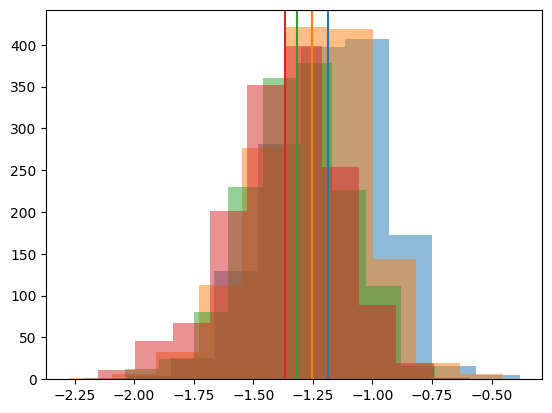

-1.1856163 -1.2542064 -1.3153344 -1.3676758


In [7]:
plen = 100
mean_lgprobs_reentrant_fake = [x[:plen].mean() for x in flatten(flatten(reentrant1_10_on_fake_ctx_lgprobs))]
mean_lgprobs_reentrant_real = [x[:plen].mean() for x in flatten(flatten(reentrant1_10_on_real_ctx_lgprobs))]
mean_lgprobs_src_fake = [x[:plen].mean() for x in flatten(flatten(src10_on_fake_ctx_lgprobs))]
mean_lgprobs_src_real = [x[:plen].mean() for x in flatten(flatten(src10_on_real_ctx_lgprobs))]

plt.hist(mean_lgprobs_src_real, alpha=0.5, color='C0')
plt.hist(mean_lgprobs_src_fake, alpha=0.5, color='C1')
plt.hist(mean_lgprobs_reentrant_fake, alpha=0.5, color='C2')
plt.hist(mean_lgprobs_reentrant_real, alpha=0.5, color='C3')

plt.axvline(np.mean(mean_lgprobs_src_real), color='C0')
plt.axvline(np.mean(mean_lgprobs_src_fake), color='C1')
plt.axvline(np.mean(mean_lgprobs_reentrant_fake), color='C2')
plt.axvline(np.mean(mean_lgprobs_reentrant_real), color='C3')
plt.show()

print(
    np.mean(mean_lgprobs_src_real),
    np.mean(mean_lgprobs_src_fake),
    np.mean(mean_lgprobs_reentrant_fake),
    np.mean(mean_lgprobs_reentrant_real)
)

The four values below the graph are the values used in Table 1.

## Base model log-probs with real context (Fig. 3)

### Real generations

In [112]:
real_probs = get_probs_for_gens(real_ctx, list(real_gens.values()))

100%|███████████████████████████████████████████| 40/40 [00:15<00:00,  2.60it/s]


### Incongruous generations

In [113]:
occupation_to_idx = {'actor': 0, 'author': 1, 'athlete': 2, 'scientist': 3, 'politician': 4, 'musician': 5}

fake_gens = [ [g for g in split] for split in real_gens.values() ]
for i, split in enumerate(fake_gens):
    for j, gen in enumerate(split):
        old_occu = extract_occupation_from_prompt(gen)
        new_occu = get_dataset.occupations[(occupation_to_idx[old_occu]+1)%len(get_dataset.occupations)]
        gen = gen.replace(
            f"best known for being {get_indef_article(old_occu) + '**' + old_occu}",
            f"best known for being {get_indef_article(new_occu) + '**' + new_occu}",
        )
        fake_gens[i][j] = gen

fake_probs = get_probs_for_gens(real_ctx, fake_gens)

### Get promotion/suppression steering probs

To get base model log probabilities for promotion and suppression steering, use the `base_model_probs.py` script. This allows you to parallelize the process of getting probabilities across multiple GPUs.

The script takes the following command-line arguments:

* `devices`: a comma-separated list of ints containing a list of GPU indices that the scripts will be using. E.g. `0,1,2,3` means that across all instances of the running scripts, GPUs 0, 1, 2, and 3 will be used.
* `device_idx`: the GPU index that this current script instance will be using. Note that this is an index into the list provided by `devices`, so if `devices` is `0,2,4`, and `device_idx` is `1`, then the script will run on GPU 2.
* `generations_path`: the path to a `.pkl` file containing the generations to be evaluated. (This is the same `.pkl` file output by the code from Section 3.1.)
* `ctx_path`: the path to a `.pkl` file containing the context to be used for evaluation. For our purposes, this should be the `results/just_kidding/real_ctx.pkl` file output in the "Get contexts" section.
* `out_prefix` (optional): a prefix for where our output file will be saved. In particular, a script running with device index `device_idx` will output to `'{out_prefix}device_{device_idx}.pkl'`.
* `layer_range` (optional): a comma-separated triple of ints `start,end,step` corresponding to a range of layers to evaluate.

**Examples**:
* To get base model log probabilities for suppression-steered generations saved to `results/just_kidding/src_generations_all_layers.pkl` on GPUs 0, 2, and 4, only looking at layers 1,3,5,...,23, then run the following commands (in parallel):
    * `python3 llm_evals.py 0,2,4 0 results/just_kidding/src_generations_all_layers.pkl results/just_kidding/real_ctx.pkl results/just_kidding/real_ctx_logprob_evals/src_steering/ 1,25,2 &`
    * `python3 llm_evals.py 0,2,4 1 results/just_kidding/src_generations_all_layers.pkl results/just_kidding/real_ctx.pkl results/just_kidding/real_ctx_logprob_evals/src_steering/ 1,25,2 &`
    * `python3 llm_evals.py 0,2,4 2 results/just_kidding/src_generations_all_layers.pkl results/just_kidding/real_ctx.pkl results/just_kidding/real_ctx_logprob_evals/src_steering/ 1,25,2 &`

### Get CAA steering probs

To get base model log probabilities for CAA steering, use the `base_model_probs_one_vec_per_layer.py` script; this script does the same thing as `base_model_probs.py` and has the same arguments, but is adapted to work with CAA steering (where we only obtain a single steering vector per layer).

### Get reentrant steering probs

For reentrant steering, we use the probabilities that we obtained on the real context in the section "Layer 10 log-probs w.r.t. real and fictitious contexts".

### Merge probabilities from all layers

#### Suppression steering

We assume that the suppression-steered generations from all layers are stored in `results/just_kidding/src_generations_all_layers.pkl`. We also assume that four GPUs were used to compute base model probabilities in parallel, and that per-device results were saved under the path `results/just_kidding/real_ctx_logprob_evals/src_steering/`. Finally, we assume that we only have results for layers in the range `range(1,25,2)`

In [115]:
generations_path = 'results/just_kidding/src_generations_all_layers.pkl'
num_devices = 4
per_device_logprobs_prefix = 'results/just_kidding/real_ctx_logprob_evals/src_steering/'
layer_range = range(1,25,2)

with open(generations_path, 'rb') as fp:
    src_gens_all_layers = pickle.load(fp)
num_training_splits = len(src_gens_all_layers[0]['generations'])
num_vecs = len(src_gens_all_layers[0]['generations'][0])
split_names = list(src_gens_all_layers[0]['generations'][0][0]['generations_dict'].keys())

all_src_steering_results = []
for i in range(num_devices):
    with open(f'{per_device_logprobs_prefix}device_{i}.pkl', "rb") as fp:
        all_src_steering_results.append(pickle.load(fp))

# layer, training_split_idx, vec_idx, split
all_src_steering_results_dict = {layer: [ [ {split_name: None for split_name in get_dataset.split_names} for vec_idx in range(num_vecs) ] for training_split_idx in range(num_training_splits) ] for layer in layer_range}

for device_results in all_src_steering_results:
    for cur_result in device_results['results']:
        all_src_steering_results_dict[cur_result['layer']][cur_result['training_split_idx']][cur_result['vec_idx']][cur_result['split_name']] = cur_result['probs']

layers = list(all_src_steering_results_dict.keys())
all_src_logprobs_per_layer = { layer : [] for layer in layers }
for layer in layers:
    for x in all_src_steering_results_dict[layer]:
        for y in x:
            for z in y.values():
                for p in z:
                    all_src_logprobs_per_layer[layer].append(np.log2(p))

#### Promotion steering

We assume that the promotion-steered generations from all layers are stored in `results/just_kidding/dst_generations_all_layers.pkl`. We also assume that four GPUs were used to compute base model probabilities in parallel, and that per-device results were saved under the path `results/just_kidding/real_ctx_logprob_evals/dst_steering/`. Finally, we assume that we only have results for layers in the range `range(1,25,2)`

In [115]:
generations_path = 'results/just_kidding/dst_generations_all_layers.pkl'
num_devices = 4
per_device_logprobs_prefix = 'results/just_kidding/real_ctx_logprob_evals/dst_steering/'
layer_range = range(1,25,2)

with open(generations_path, 'rb') as fp:
    dst_gens_all_layers = pickle.load(fp)
num_training_splits = len(dst_gens_all_layers[0]['generations'])
num_vecs = len(dst_gens_all_layers[0]['generations'][0])
split_names = list(dst_gens_all_layers[0]['generations'][0][0]['generations_dict'].keys())

all_dst_steering_results = []
for i in range(num_devices):
    with open(f'{per_device_logprobs_prefix}device_{i}.pkl', "rb") as fp:
        all_dst_steering_results.append(pickle.load(fp))

# layer, training_split_idx, vec_idx, split
all_dst_steering_results_dict = {layer: [ [ {split_name: None for split_name in get_dataset.split_names} for vec_idx in range(num_vecs) ] for training_split_idx in range(num_training_splits) ] for layer in layer_range}

for device_results in all_dst_steering_results:
    for cur_result in device_results['results']:
        all_dst_steering_results_dict[cur_result['layer']][cur_result['training_split_idx']][cur_result['vec_idx']][cur_result['split_name']] = cur_result['probs']

layers = list(all_dst_steering_results_dict.keys())
all_dst_logprobs_per_layer = { layer : [] for layer in layers }
for layer in layers:
    for x in all_dst_steering_results_dict[layer]:
        for y in x:
            for z in y.values():
                for p in z:
                    all_dst_logprobs_per_layer[layer].append(np.log2(p))

#### CAA steering

We assume that the CAA-steered generations from all layers are stored in `results/just_kidding/caa_generations_all_layers.pkl`. We also assume that four GPUs were used to compute base model probabilities in parallel, and that per-device results were saved under the path `results/just_kidding/real_ctx_logprob_evals/caa_steering/`. Finally, we assume that we only have results for layers in the range `range(1,25,2)`

In [ ]:
generations_path = 'results/just_kidding/caa_generations_all_layers.pkl'
num_devices = 4
per_device_logprobs_prefix = 'results/just_kidding/real_ctx_logprob_evals/caa_steering/'
layer_range = range(1,25,2)

with open(generations_path, 'rb') as fp:
    caa_gens_all_layers = pickle.load(fp)

all_caa_steering_results = []
for i in range(num_devices):
    with open(f'{per_device_logprobs_prefix}device_{i}.pkl', "rb") as fp:
        all_caa_steering_results.append(pickle.load(fp))

# layer, training_split_idx, vec_idx, split
all_caa_steering_results_dict = {layer: {split_name: None for split_name in get_dataset.split_names} for layer in layer_range}

for device_results in all_caa_steering_results:
    for cur_result in device_results['results']:
        all_caa_steering_results_dict[cur_result['layer']][cur_result['split_name']] = cur_result['probs']

layers = list(all_caa_steering_results_dict.keys())
all_caa_logprobs_per_layer = { layer : [] for layer in layers }
for layer in layers:
    for split in all_caa_steering_results_dict[layer]:
        for p in split:
            all_caa_logprobs_per_layer[layer].append(np.log2(p))

### Plot and analyze (Fig. 3)

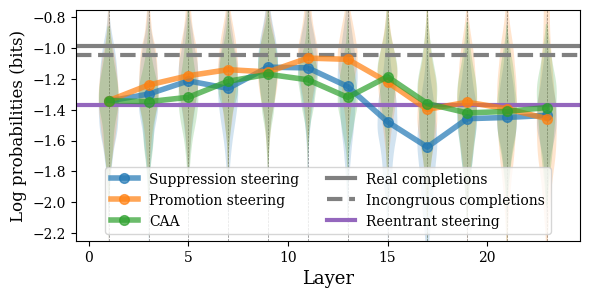

In [171]:
import numpy as np

pslice = slice(0, 100)

mean_logprobs_per_layer = { layer : [ np.mean(x[pslice]) for x in all_src_logprobs_per_layer[layer] ] for layer in layers }
vp = plt.violinplot(list(mean_logprobs_per_layer.values()), widths=1, showmedians=False, showextrema=False, positions=layers)
for p in vp['bodies']:
    p.set_zorder(-2)
    p.set_alpha(0.2)
plt.plot(layers, [np.median(x) for x in mean_logprobs_per_layer.values()], c='C0', label="Suppression steering", zorder=1, marker='.', alpha=0.7)

mean_logprobs_per_layer = { layer : [ np.mean(x[pslice]) for x in all_dst_logprobs_per_layer[layer] ] for layer in layers }
vp = plt.violinplot(list(mean_logprobs_per_layer.values()), widths=1, showmedians=False, showextrema=False, positions=layers)
for p in vp['bodies']:
    p.set_zorder(-2)
    p.set_alpha(0.2)
plt.plot(layers, [np.median(x) for x in mean_logprobs_per_layer.values()], c='C1', label="Promotion steering", zorder=1, marker='.', alpha=0.7)

mean_logprobs_per_layer = { layer : [ np.mean(x) for x in all_caa_logprobs_per_layer[layer] ] for layer in layers }
vp = plt.violinplot(list(mean_logprobs_per_layer.values()), widths=1, showmedians=False, showextrema=False, positions=layers)
for p in vp['bodies']:
    p.set_zorder(-2)
    p.set_alpha(0.2)
plt.plot(layers, [np.median(x) for x in mean_logprobs_per_layer.values()], c='C2', label="CAA", marker='.', alpha=0.7)

for l in layers:
    plt.axvline(l, c='gray', linewidth=0.5, linestyle='dashed', zorder=-5)

plt.axhline(np.mean([np.log2(x[pslice]).mean() for x in flatten(real_probs)]), c='gray', linewidth=3, label="Real completions", zorder=-1)
plt.axhline(np.mean([np.log2(x[pslice]).mean() for x in flatten(fake_probs)]), c='gray', linewidth=3, linestyle='dashed', label="Incongruous completions", zorder=-1)

plt.axhline(-1.3676, linewidth=3, label="Reentrant steering", zorder=-1, color='C4')

plt.gca().figure.set_size_inches(6.5,3)

plt.ylim(ymax=-0.75, ymin=-2.25)

plt.xlabel("Layer", fontsize=13)
plt.ylabel("Log probabilities (bits)", fontsize=12)
#plt.title("Mean log probs of steered completion in base model")
plt.legend(loc='lower center', ncols=2)
plt.show()

## Real vs. fictitious context logprobs

In [191]:
real_ctx_tokens = tokenizer(real_ctx, return_tensors='pt').input_ids.cpu()
fake_ctx_tokens = tokenizer(fake_ctx, return_tensors='pt').input_ids.cpu()

In [194]:
with torch.no_grad():
    real_ctx_logits = base_model(tokenizer(real_ctx, return_tensors='pt').input_ids).logits
    real_ctx_lgprobs = real_ctx_logits[0].softmax(dim=-1).detach().cpu().float().log2()
    del real_ctx_logits
    unoom()
    fake_ctx_logits = base_model(tokenizer(fake_ctx, return_tensors='pt').input_ids).logits
    fake_ctx_lgprobs = fake_ctx_logits[0].softmax(dim=-1).detach().cpu().float().log2()

In [197]:
real_ctx_correct_lgprobs = torch.gather(real_ctx_lgprobs[:-1], 1, real_ctx_tokens[0, 1:].unsqueeze(1)).squeeze(1)
fake_ctx_correct_lgprobs = torch.gather(fake_ctx_lgprobs[:-1], 1, fake_ctx_tokens[0, 1:].unsqueeze(1)).squeeze(1)

In [200]:
real_ctx_correct_lgprobs.mean().item(), fake_ctx_correct_lgprobs.mean().item()


(-1.0254971981048584, -1.301758885383606)

This is where we get the numbers cited as "information complexity" towards the end of Section 3.3.

## Dot product classifiers

### Setup functions

In [234]:
import tqdm

@torch.no_grad()
def get_dots_on_prompts(model, tokenizer, prompts, vector, layer, batch_size=40, token=None):
    hook_point = f'blocks.{layer}.hook_resid_pre'
    dots = []
    for i in tqdm.tqdm(range(0, len(prompts), batch_size)):
        cur_prompts = prompts[i:i+batch_size]

        outlist = []
        activs_hook = (layer, steering_opt.make_activs_hook_hf(outlist))
        token_info = tokenizer(cur_prompts, return_tensors='pt', padding=True, padding_side='right')
        lengths = (token_info.input_ids != 0).sum(dim=-1).detach().cpu().numpy()
        with steering_opt.hf_hooks_contextmanager(model, [activs_hook]):
            model(**token_info)
        activs_batch = outlist[0].float()
        for j, activs in enumerate(activs_batch):
            activs = activs[:lengths[j]]
            if token is not None:
                if isinstance(token, int):
                    activs = activs[token][None]
                elif isinstance(token, slice):
                    activs = activs[token]
            cur_dots = torch.einsum('td, d -> t', activs.to(device).float(), vector.to(device)).mean().detach().cpu().numpy()
            dots.append(cur_dots)
    return np.array(dots)

In [101]:
layers = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23]

### CAA vecs

In [104]:
# we assume that all CAA vectors were saved to results/just_kidding/caa_vecs_all_layers.pkl
with open('results/just_kidding/caa_vecs_all_layers.pkl', 'rb') as fp:
    caa_vecs = pickle.load(fp)
    
caa_dots = { layer: { 'real': [], 'fake': [] } for layer in layers }

for layer in layers:
    vec = torch.from_numpy(caa_vecs[layer]).to(device)
    caa_dots[layer]['real'] = get_dots_on_prompts(model, tokenizer, get_dataset.real_prompts, vec, layer)
    caa_dots[layer]['fake'] = get_dots_on_prompts(model, tokenizer, get_dataset.fake_prompts, vec, layer)

100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  5.58it/s]


In [108]:
with open('results/just_kidding/caa_dots.pkl', 'wb') as fp:
    pickle.dump(caa_dots, fp)

### Src vecs

In [107]:
with open('results/just_kidding/src_generations_all_layers.pkl', 'rb') as fp:
    src_gens = pickle.load(fp)

src_vecs = { layer:
    [torch.from_numpy(src_gens[layer]['generations'][i][0]['vector']).cuda() for i in range(len(src_gens[layer]['generations']))]
for layer in layers }

src_dots = { layer: [ { 'real': [], 'fake': [] } for vec_id in range(len(src_vecs[layer])) ] for layer in layers }

for layer in layers:
    for i, vec in enumerate(src_vecs[layer]):
        src_dots[layer][i]['real'] = get_dots_on_prompts(model, tokenizer, get_dataset.real_prompts, vec, layer)
        src_dots[layer][i]['fake'] = get_dots_on_prompts(model, tokenizer, get_dataset.fake_prompts, vec, layer)

100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  5.51it/s]


In [109]:
with open('results/just_kidding/src_dots.pkl', 'wb') as fp:
    pickle.dump(src_dots, fp)

### Dst vecs

In [110]:
with open('results/just_kidding/dst_generations_all_layers.pkl', 'rb') as fp:
    dst_gens = pickle.load(fp)

dst_vecs = { layer:
    [torch.from_numpy(dst_gens[layer]['generations'][i][0]['vector']).cuda() for i in range(len(dst_gens[layer]['generations']))]
for layer in layers }

dst_dots = { layer: [ { 'real': [], 'fake': [] } for vec_id in range(len(dst_vecs[layer])) ] for layer in layers }

for layer in layers:
    for i, vec in enumerate(dst_vecs[layer]):
        dst_dots[layer][i]['real'] = get_dots_on_prompts(model, tokenizer, get_dataset.real_prompts, vec, layer)
        dst_dots[layer][i]['fake'] = get_dots_on_prompts(model, tokenizer, get_dataset.fake_prompts, vec, layer)

100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  5.49it/s]


In [111]:
with open('results/just_kidding/dst_dots.pkl', 'wb') as fp:
    pickle.dump(dst_dots, fp)

### Reentrant

In [240]:
with open('reentrant_1_10_gens.pkl', 'rb') as fp:
    reentrant_gens = pickle.load(fp)

reentrant_vecs = [torch.from_numpy(reentrant_gens['generations'][i][0]['vector']).cuda() for i in range(len(reentrant_gens['generations']))]

reentrant_dots = [ { 'real': [], 'fake': [] } for vec_id in range(len(reentrant_vecs)) ]

for i, vec in enumerate(reentrant_vecs):
    reentrant_dots[i]['real'] = get_dots_on_prompts(model, tokenizer, get_dataset.real_prompts, vec, 10)
    reentrant_dots[i]['fake'] = get_dots_on_prompts(model, tokenizer, get_dataset.fake_prompts, vec, 10)

100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  5.68it/s]


### Plot the dots (Fig. 4)

In [197]:
with open('results/just_kidding/src_dots.pkl', 'rb') as fp:
    src_dots = pickle.load(fp)

with open('results/just_kidding/dst_dots.pkl', 'rb') as fp:
    dst_dots = pickle.load(fp)

with open('results/just_kidding/caa_dots.pkl', 'rb') as fp:
    caa_dots = pickle.load(fp)

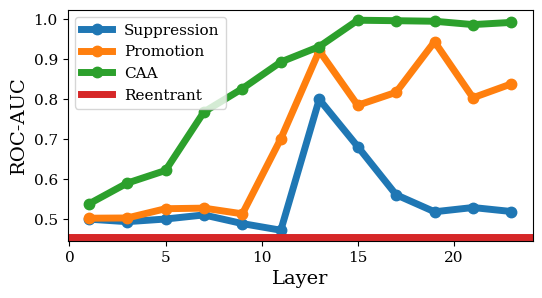

In [274]:
import numpy as np
import sklearn.metrics

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 11
plt.rcParams['lines.linewidth'] = 5
plt.rcParams['lines.markersize'] = 15


mean_real_dots = { layer : flatten( [ cur_vec_split['real'] for cur_vec_split in src_dots[layer]] ) for layer in src_dots.keys() }
mean_fake_dots = { layer : flatten( [ cur_vec_split['fake'] for cur_vec_split in src_dots[layer]] ) for layer in src_dots.keys() }
roc_aucs = {}
for layer in src_dots.keys():
    roc_aucs[layer] = sklearn.metrics.roc_auc_score(
        np.concatenate([np.ones(len(mean_real_dots[layer])), np.zeros(len(mean_fake_dots[layer]))]),
        np.concatenate([mean_real_dots[layer], mean_fake_dots[layer]])
    )
plt.plot(roc_aucs.keys(), roc_aucs.values(), marker='.', label='Suppression')

mean_real_dots = { layer : flatten( [ cur_vec_split['real'] for cur_vec_split in dst_dots[layer]] ) for layer in dst_dots.keys() }
mean_fake_dots = { layer : flatten( [ cur_vec_split['fake'] for cur_vec_split in dst_dots[layer]] ) for layer in dst_dots.keys() }
roc_aucs = {}
for layer in src_dots.keys():
    roc_aucs[layer] = sklearn.metrics.roc_auc_score(
        np.concatenate([np.ones(len(mean_real_dots[layer])), np.zeros(len(mean_fake_dots[layer]))]),
        np.concatenate([mean_real_dots[layer], mean_fake_dots[layer]])
    )
plt.plot(roc_aucs.keys(), roc_aucs.values(), marker='.', label='Promotion')

mean_real_dots = { layer : caa_dots[layer]['real'] for layer in caa_dots.keys() }
mean_fake_dots = { layer : caa_dots[layer]['fake'] for layer in caa_dots.keys() }
roc_aucs = {}
for layer in src_dots.keys():
    roc_aucs[layer] = sklearn.metrics.roc_auc_score(
        np.concatenate([np.ones(len(mean_real_dots[layer])), np.zeros(len(mean_fake_dots[layer]))]),
        np.concatenate([mean_real_dots[layer], mean_fake_dots[layer]])
    )
plt.plot(roc_aucs.keys(), roc_aucs.values(), marker='.', label='CAA')

mean_real_dots = flatten( [ cur_vec_split['real'] for cur_vec_split in reentrant_dots] )
mean_fake_dots = flatten( [ cur_vec_split['fake'] for cur_vec_split in reentrant_dots] )
roc_auc = sklearn.metrics.roc_auc_score(
    np.concatenate([np.ones(len(mean_real_dots)), np.zeros(len(mean_fake_dots))]),
    np.concatenate([mean_real_dots, mean_fake_dots])
)
plt.axhline(roc_auc, label='Reentrant', color='C3')

#plt.title("ROC-AUC of steering vector dot products\nfor classifying real/fake prompts")
plt.ylabel("ROC-AUC", fontsize=14)
plt.xlabel("Layer", fontsize=14)

plt.legend()

plt.gca().figure.set_size_inches(6,3)

plt.show()